# Exploration of Clothing Dataset and Qwen2.5-VL-7B as Classifier

The dataset I used in this notebook contains 5403 images of clothing items of 20 different classes. The images were either crowdsourced or from a data collection company. The base model achieve a ~93.5% accuracy on the validation set of 341 samples.

In following cells, I
1. Show sample images from the validation set
2. Perform EDA on the full dataset
3. Evaluate the performance of the base Qwen2.5-VL-7B model in classifying the clothing label

Details on the data collection process: https://medium.com/data-science-insider/clothing-dataset-5b72cd7c3f1f

Full dataset of images and metadata: https://github.com/alexeygrigorev/clothing-dataset?tab=readme-ov-file

Subset of dataset that I pulled the validation set from: https://github.com/alexeygrigorev/clothing-dataset-small

Details on Qwen2.5-VL-7B-Instruct: https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct

## Install and import dependencies

In [ ]:
%%capture
# Install required packages
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit_learn
!pip install keras
!pip install tensorflow
!pip install huggingface_hub[hf_transfer]
!pip install qwen-vl-utils[decord]==0.0.8

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, confusion_matrix,roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay

import torch
from huggingface_hub import hf_hub_download, snapshot_download
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

## Sample Images from validation set

Looking at the images and labels, the difference between 'shirt' and 't-shirt' is that the shirts are all button up shirts while t-shirts are all short sleeve shirts. Another observation is that the long sleeves and outwear categories are often similar.

Label: hat


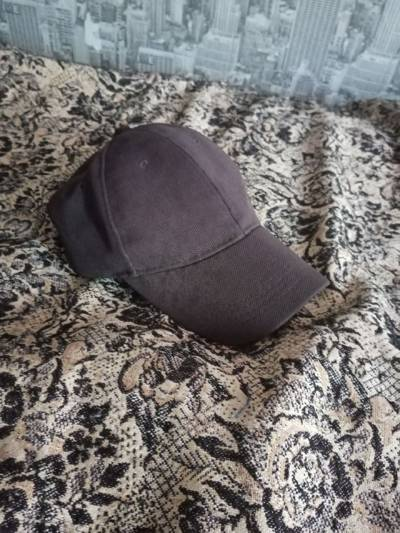



Label: skirt


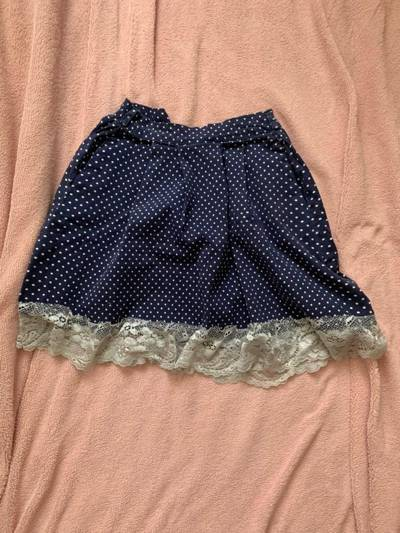



Label: longsleeve


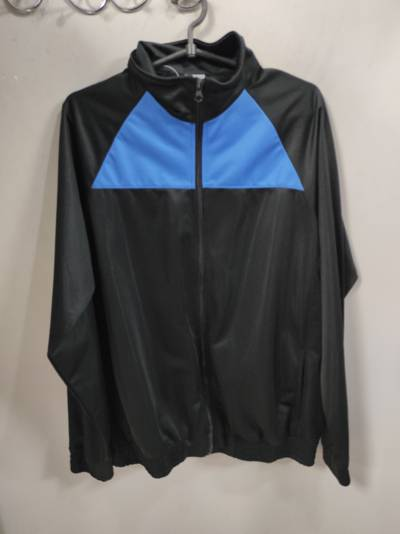



Label: shoes


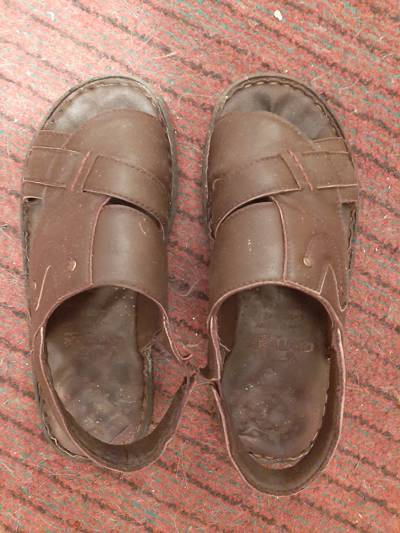



Label: shorts


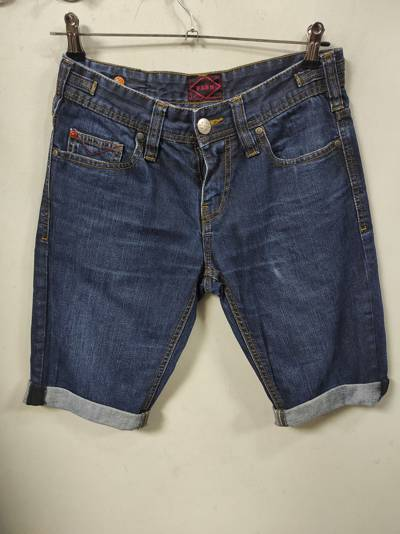



Label: button up shirt


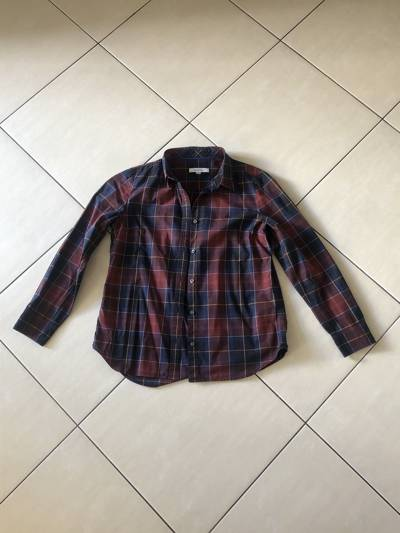



Label: outwear


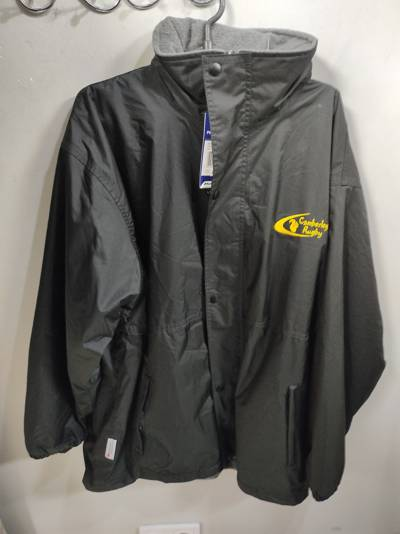



Label: dress


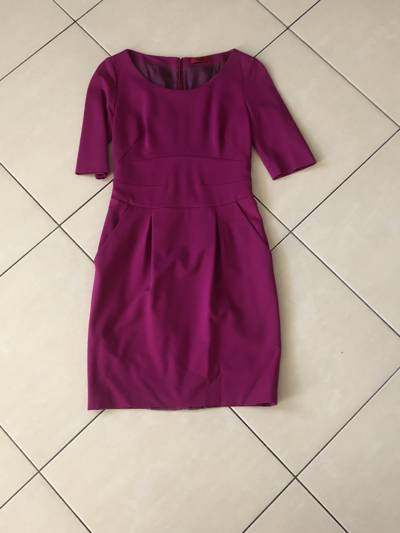



Label: t-shirt


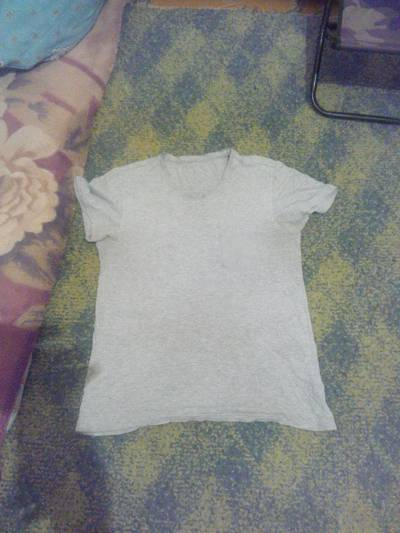



Label: pants


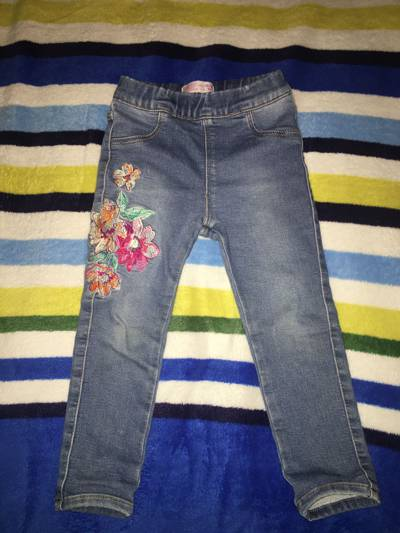

In [ ]:
from IPython.display import Image
image_folder = '/content/drive/MyDrive/MIDS Capstone/validation'

# for each subfolder, show the first image file
for subfolder in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, subfolder)
    if os.path.isdir(subfolder_path):
        image_files = os.listdir(subfolder_path)
        if image_files:
            first_image_file = image_files[0]
            first_image_path = os.path.join(subfolder_path, first_image_file)
            print(f"Label: {subfolder}")
            display(Image(filename=first_image_path))
            print("\n")

## EDA for full dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MIDS Capstone/images.csv')
print("Number of Rows: " + str(len(df)))
df.head(5)

Number of Rows: 5403


,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


Number of Unique Labels: 20


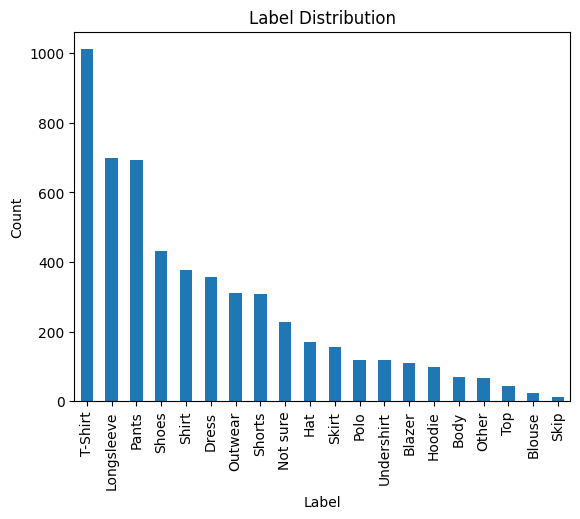

In [ ]:
# visualize label distribution
print("Number of Unique Labels: " + str(len(df['label'].unique())))
df['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

#### Visualize percentage of kids' clothing items vs adult clothing items

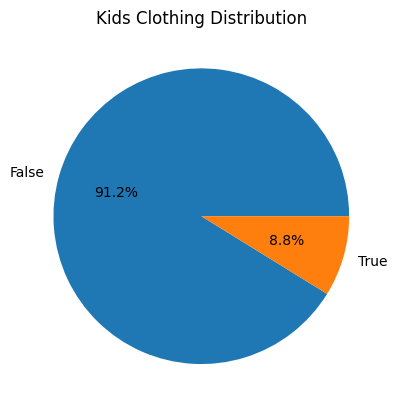

In [ ]:
# pie chart of percentage of kids clothing vs non kids clothing
df['kids'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Kids Clothing Distribution')
plt.ylabel('')
plt.show()

#### Explore sender_id which represents who sent in the image of the clothing item

In [ ]:
# summary statistics for the categorical variable sender_id

# calculate average count and std
df['sender_id'] = pd.Categorical(df['sender_id'])
sender_id_counts = df['sender_id'].value_counts()
average_count = sender_id_counts.mean()
std_count = sender_id_counts.std()
print("Average Count:", average_count)
print("Standard Deviation of Count:", std_count)
print()

# summary stats
sender_id_summary = df['sender_id'].describe()
print(sender_id_summary)

Average Count: 15.393162393162394
Standard Deviation of Count: 53.87301852079697

count     5403
unique     351
top        204
freq       646
Name: sender_id, dtype: int64


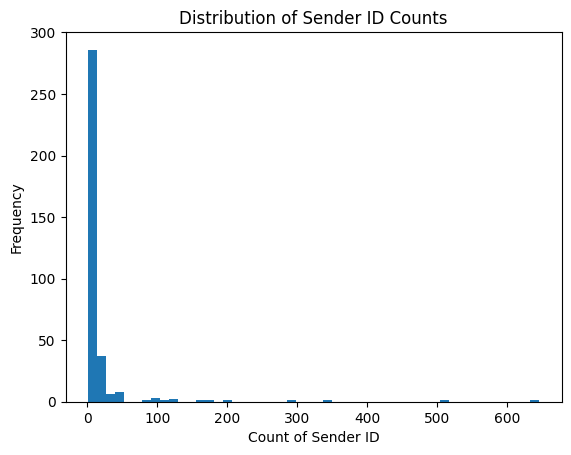

In [ ]:
# visualize distribution of sender_id counts
sender_id_counts = df['sender_id'].value_counts()
plt.hist(sender_id_counts, bins=50)
plt.xlabel('Count of Sender ID')
plt.ylabel('Frequency')
plt.title('Distribution of Sender ID Counts')
plt.show()

Seems like there are some outliers with much largers counts than the average. Also, the majority appears to be between 0-50. Let's remove the larger counts and revisualize to zoom in on the distribution.

In [ ]:
# calculate average count and std with outliers removed
sender_id_counts = df['sender_id'].value_counts()
sender_id_counts_no_outliers = sender_id_counts[sender_id_counts < 50]
average_count = sender_id_counts_no_outliers.mean()
std_count = sender_id_counts_no_outliers.std()
print("Average Count:", average_count)
print("Standard Deviation of Count:", std_count)
print("Number of Unique Senders: " + str(len(sender_id_counts_no_outliers)))
print("Number of Senders Removed: " + str(len(sender_id_counts) - len(sender_id_counts_no_outliers)))

Average Count: 6.779761904761905
Standard Deviation of Count: 8.786642233196137
Number of Unique Senders: 336
Number of Senders Removed: 15


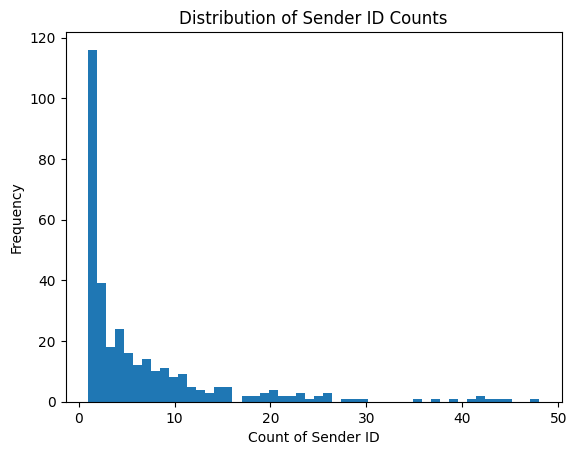

In [ ]:
# visualize distribution of sender_id counts
plt.hist(sender_id_counts_no_outliers, bins=50)
plt.xlabel('Count of Sender ID')
plt.ylabel('Frequency')
plt.title('Distribution of Sender ID Counts')
plt.show()

### EDA summary:
1. Inbalanced label distribution with T-Shirt (1011 rows) being the most and Blouse (23 rows) having the least
2. Majority (91%) are adult clothing items.
3. Sender of the clothing images are quite skewed. Most people sent in around 0-10 clothing images, but some sent in as many as 646 images (likely from the data collection company).

## Evaluate base Qwen 2.5-VL-7B on val set

#### Download and Set up Model

In [ ]:
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'

In [ ]:
# Define the model repository ID
repo_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# Download the model file using hf_transfer
file_path = snapshot_download(repo_id)

print(f"Model downloaded to: {file_path}")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/353 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-7B-Instruct/snapshots/41bf8b5ecf63c81d5e5f5932693663ac4b5c4595


In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

#### Define Simple Prompt
I redefined the 'shirt' folder/label to 'button up shirt' in my local storage before running this.



In [ ]:
# get label values in format of "val1, val2, val3, etc" to feed into prompt
labels_str = ""
image_folder = '/content/drive/MyDrive/MIDS Capstone/validation'
for subfolder in os.listdir(image_folder):
    labels_str += subfolder + ", "
labels_str = labels_str[:-2]

# define prompt string
prompt = f"Classify this image as one of the following: {labels_str}. Answer with only the label name."
print(prompt)

Classify this image as one of the following: hat, skirt, longsleeve, shoes, shorts, button up shirt, outwear, dress, t-shirt, pants. Answer with only the label name.


#### Test on one sample (first t-shirt image)

In [ ]:
sample_path = "/content/drive/MyDrive/MIDS Capstone/validation/t-shirt/a5e1addc-13cf-4d7e-be46-dfefa23beee4.jpg"

# define message with image and prompt
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": sample_path,
            },
            {"type": "text", "text": prompt},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['t-shirt']


### Test on entire validation set

In [ ]:
# took ~ 6min 40s on A100
image_folder = '/content/drive/MyDrive/MIDS Capstone/validation'
true_labels = []
pred_labels = []

# loop through each subfolder and predict class of each image in subfolder
for subfolder in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, subfolder)
    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)

        # define message with image and prompt
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image_path,
                    },
                    {"type": "text", "text": prompt},
                ],
            }
        ]

        # Preparation for inference
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Inference: Generation of the output
        generated_ids = model.generate(**inputs, max_new_tokens=128)
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )

        # save output
        pred_labels.append(output_text[0])
        true_labels.append(subfolder)

In [ ]:
# create list of labels
labels = []
for subfolder in os.listdir(image_folder):
    labels.append(subfolder)
labels

['hat',
 'skirt',
 'longsleeve',
 'shoes',
 'shorts',
 'button up shirt',
 'outwear',
 'dress',
 't-shirt',
 'pants']

Number of Validation Samples: 341
Accuracy: 0.9354838709677419


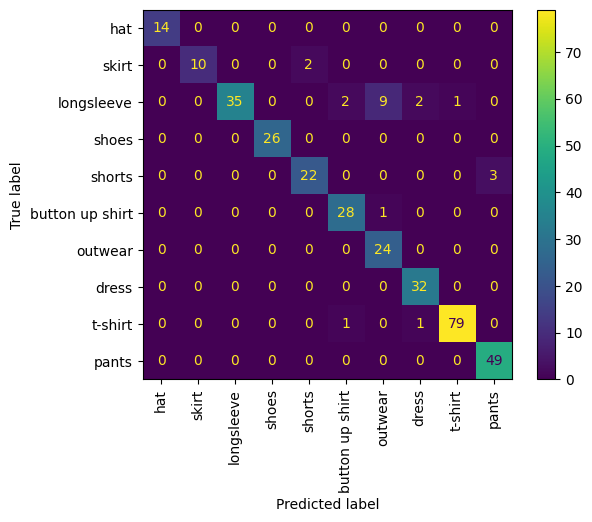

In [ ]:
# compute metrics and confusion matrix
def eval_model(preds, true_labels):
    print("Accuracy: " + str(sum(1 for x, y in zip(preds, true_labels) if x == y) / len(true_labels)))

    cm = confusion_matrix(true_labels, preds, labels=labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.xticks(rotation=90)
    plt.show()

print("Number of Validation Samples: " + str(len(true_labels)))
eval_model(pred_labels, true_labels)

Seems to do pretty good overall. Most of the mistakes was in predicting a 'longsleeve' as 'outwear' which makes sense in my opinion since the categories are very similar. I observed some images in the 'longsleeves' folder being jackets so I think it is a bit ambigious. My vote would be redefining the label categories in our MVP e.g. getting rid of 'longsleeve' or making it something more intuitive. We could fine tune this model or use the larger 72B parameter version of this model if we want to further improve the performance.